In [3]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
target_layer = model.layer4[1].conv2

In [6]:
activations = []
gradients = []

def fwd_hook(module, inp, out):
    activations.append(out.detach())

def bwd_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0].detach())

target_layer.register_forward_hook(fwd_hook)
target_layer.register_full_backward_hook(bwd_hook)

In [10]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

img = Image.open("dog.jpg").convert("RGB")
x = preprocess(img).unsqueeze(0)

In [11]:
out = model(x)
pred_class = out.argmax(dim=1).item()
score = out[0, pred_class]
model.zero_grad()
score.backward()

In [14]:
weights = gradients[0].mean(dim=[2,3]).squeeze(0)
cam = torch.zeros_like(activations[0][0,0])
for k in range(activations[0].shape[1]):
    cam += weights[k] * activations[0][0,k]

cam = F.relu(cam)
cam = cam / cam.max()
cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                    size=(224,224), mode='bilinear',
                    align_corners=False)[0,0].cpu().numpy()

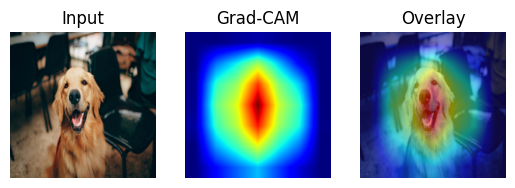

In [15]:
img_np = np.array(img.resize((224,224)))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(heatmap, 0.5, img_np, 0.5, 0)

plt.subplot(1,3,1); plt.title("Input"); plt.imshow(img_np); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM"); plt.imshow(cam, cmap="jet"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.show()